In [1]:
import sys
import re
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp

from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold


sns.set(palette='pastel')

# The order of features cannot be changed, because all function follow this order.
features_en = ['LDH', 'CRP', 'L%']
features_zh = ['乳酸脱氢酶', '超敏C反应蛋白', '淋巴细胞(%)']

# Load data

## Tongji

In [3]:
def merge_data_by_sliding_window(data, n_days=1, dropna=True, subset=None, time_form='diff'):
    """Slide window to merge data

    :param data: Time series data. The first-level row index is PATIENT_ID, and the second-level row index is RE_DATE.
    :param n_days: The length of the window.
    :param dropna: Whether to delete what is missing after sliding window merge
    :param subset: pd.DataFrame().dropna() parameter
    :param time_form: Return time index of data, 'diff' or 'timestamp'.
    :return: The merged data. The first-level row index is PATIENT_ID, and the second-level row index is t_diff or RE_DATE,
             depending on "time_form"
    """
    data = data.reset_index(level=1)

    # 距离出院时长 (time interval before discharge)
    t_diff = data['出院时间'].dt.normalize() - data['RE_DATE'].dt.normalize()
    data['t_diff'] = t_diff.dt.days.values // n_days * n_days
    data = data.set_index('t_diff', append=True)

    # 滑窗合并 (combine time windows)
    data = (
        data
        .groupby(['PATIENT_ID', 't_diff']).ffill()
        .groupby(['PATIENT_ID', 't_diff']).last()
    )

    if dropna:
        data = data.dropna(subset=subset)
        
    if time_form == 'timestamp':
        data = (
            data
            .reset_index(level=1, drop=True)
            .set_index('RE_DATE', append=True)
        )
    elif time_form == 'diff':
        data = data.drop(columns=['RE_DATE'])

    return data

In [4]:
def load_tj_data():
    """
    Load Tongji 375 + 110 data
    <=10 days data
    """
    p_read_375 = '../新冠荷兰数据/data/time_series_375.parquet'
    df375 = pd.read_parquet(p_read_375)
    df375 = merge_data_by_sliding_window(df375, subset=features_zh)
    df375 = df375[features_zh+['出院方式']]
    df375['Class'] = 'Tongji (last 10 days)'
#     df375['Class'] = 'Tongji375 (last 10 days)'

    p_read_110 = '../新冠荷兰数据/data/time_series_test_110.parquet'
    df110 = pd.read_parquet(p_read_110)
    df110 = merge_data_by_sliding_window(df110, subset=features_zh)
    df110 = df110[features_zh+['出院方式']]
    df110['Class'] = 'Tongji (last 10 days)'
#     df110['Class'] = 'Tongji110 (last 10 days)'

    df = pd.concat([df375, df110])
    df = df.query("`t_diff` <= 10")
    df = df.reset_index(drop=True)
    df.columns = features_en + ['Survival/death', 'Class']
    df['Survival/death'] = df['Survival/death'].astype(int)

    return df

load_tj_data()

,LDH,CRP,L%,Survival/death,Class
0,198.0,2.6,28.7,0,Tongji (last 10 days)
1,269.0,3.6,33.1,0,Tongji (last 10 days)
2,179.0,0.8,30.5,0,Tongji (last 10 days)
3,231.0,0.3,31.0,0,Tongji (last 10 days)
4,354.0,1.5,3.0,0,Tongji (last 10 days)
...,...,...,...,...,...
556,501.0,317.6,1.3,1,Tongji (last 10 days)
557,417.0,228.2,1.0,1,Tongji (last 10 days)
558,477.0,293.5,0.9,1,Tongji (last 10 days)
559,509.0,172.1,1.4,1,Tongji (last 10 days)


## Netherlands

In [5]:
def load_nl_data():
    """
    Load Netherlands data
    <=10 days data
    """
    df = pd.read_excel("../新冠荷兰数据/data/Quanjel_dataset_1591655498_1.xlsx")
    
    df = df[df['Date of discharge'] != 'No']
    df['Date of discharge'] = pd.to_datetime(df['Date of discharge'])
    df['diff'] = (df['Date of discharge'] - df['Date blood analysis']).dt.days
    
    # Select the data and rename it
    df['Survival/death'] = df['Survival/death'].map({'Alive': 0, 'Deceased': 1})
    df = df.query("`diff` <= 10").reset_index(drop=True)
    df = df.rename(columns={'LD': 'LDH', 'Percentage lymphocytes': 'L%'})
    df = df[features_en + ['Survival/death']]
    df['Class'] = 'AH (last 10 days)'
    df['Survival/death'] = df['Survival/death'].astype(int)

    return df

load_nl_data()

,LDH,CRP,L%,Survival/death,Class
0,316,77,20.909091,0,AH (last 10 days)
1,444,82,11.911765,0,AH (last 10 days)
2,323,58,12.586207,0,AH (last 10 days)
3,244,20,27.254902,0,AH (last 10 days)
4,252,33,20.227273,0,AH (last 10 days)
...,...,...,...,...,...
246,374,58,14.366197,0,AH (last 10 days)
247,198,36,23.571429,0,AH (last 10 days)
248,416,102,10.267857,0,AH (last 10 days)
249,186,20,25.102041,0,AH (last 10 days)


## France

In [6]:
def load_fr_data():
    """
    Load France data
    Because there is no detection time, so take the last detection result
    """
    df = pd.read_csv('../新冠法国数据/data/2/1903_1_data_0_qc8yzj.csv', header=[0, 1], sep=';')
    idx = df[('Unnamed: 0_level_0', 'id')]
    idx.name = 'id'
    df = df.set_index(idx)
    
    # Base data
    df_base = df.iloc[:, :10]
    df_base = df_base.droplevel(level=0, axis=1)
    df_base = df_base[['id', 'date_hospital_admi', 'date_hospital_end', 'date_death', 'ICU_DC']]
    df_base['date_hospital_admi'] = pd.to_datetime(df_base['date_hospital_admi'], format="%d/%m/%Y")
    df_base['date_hospital_end']  = pd.to_datetime(df_base['date_hospital_end'], format="%d/%m/%Y")
    df_base['date_death']         = pd.to_datetime(df_base['date_death'], format="%d/%m/%Y")
    df_base['end-admi'] = (df_base['date_hospital_end'] - df_base['date_hospital_admi']).dt.days
    
    # Admission data: HR_min, HR_max, SBP_min, SBP_max, DBP_min, DBP_max, SAPSII, RR, GCS
    df_admi = df.iloc[:, 10:19]
    
    # Detection data
    df_dete = df.iloc[:, 19:]
    df_dete = df_dete.rename(columns=lambda x: int(re.sub('Day ', '', x)), level=0)
    df_dete = df_dete.rename(columns=lambda x: re.sub('\d', '', x), level=1).stack(level=0)
    df_dete = df_dete.rename(columns={'CRPt': 'CRP', 'LDHt': 'LDH', 'L_perct': 'L%'})
    df_dete.index.names = ['id', 'dete_num']

    df = df_dete.join(df_base, on='id').drop(columns=['id'])
    
    # Select the data and rename it
    df = df.dropna(subset=['ICU_DC'])
    df = df.groupby(level=0).last()
    df = df.reset_index(drop=True)
    df = df.rename(columns={'ICU_DC': 'Survival/death'})
    df = df[features_en+['Survival/death']]
    df['Class'] = 'FO (last)'
    df['Survival/death'] = df['Survival/death'].astype(int)

    return df

load_fr_data()

,LDH,CRP,L%,Survival/death,Class
0,280.000000,67.10,7.692308,0,FO (last)
1,362.000000,174.00,24.666667,0,FO (last)
2,1230.000000,126.00,16.500000,1,FO (last)
3,577.142857,243.00,10.952381,1,FO (last)
4,723.000000,83.80,6.296296,0,FO (last)
...,...,...,...,...,...
93,556.000000,26.50,17.460317,0,FO (last)
94,303.000000,217.80,6.060606,0,FO (last)
95,480.142857,308.70,2.962963,0,FO (last)
96,352.000000,14.60,30.476190,0,FO (last)


## New York

In [7]:
def load_ny_data():
    """
    Load New York data
    Because there is no detection time, take the last detection result
    """
    df = pd.read_csv('../新冠纽约数据/data/Zanos_Dataset_1_1593181746_12.csv', index_col=0)
    df = df[['Last_LDH', 'Last_CRP', 'Last_Lymph', 'Expired_Outcome']]
    df.columns = features_en + ['Survival/death']
    df = df.dropna(subset=['Survival/death'])
    df = df.reset_index(drop=True)
    df['Class'] = 'NH (last)'
    df['Survival/death'] = df['Survival/death'].astype(int)

    return df

load_ny_data()

,LDH,CRP,L%,Survival/death,Class
0,641,57.5,4.5,1,NH (last)
1,334,100.4,0.9,1,NH (last)
2,568,220.7,2.8,1,NH (last)
3,613,19.3,0.9,1,NH (last)
4,271,25.1,2.6,1,NH (last)
...,...,...,...,...,...
1033,301,4.1,8.0,0,NH (last)
1034,1126,61.5,15.2,0,NH (last)
1035,340,39.5,6.1,1,NH (last)
1036,491,73.3,21.9,1,NH (last)


## Jinyintan

In [19]:
def load_jyt_data():
    """
    Load Jinyintan data
    <=10 days data
    """
    df1 = pd.read_parquet("E:\袁烨团队\新冠肺炎特征选择\Project\Paper2\汇总\data/金银潭100/jyt100.parquet")
    df2 = pd.read_parquet("E:\袁烨团队\新冠肺炎特征选择\Project\Paper2\汇总\data/金银潭100/jyt46.parquet")
    df = pd.concat([df1, df2])
    df = df.reset_index()
    df['t_diff'] = (df['出院时间'] - df['RE_DATE']).dt.days
    
    df = df.query("`t_diff` <= 10")
    df = df[features_zh + ['出院方式']]
    df.columns = features_en + ['Survival/death']
    df['Class'] = 'Jinyintan (last 10 days)'
    df = df.reset_index(drop=True)
    return df

# load_jyt_data()

## Shenzhen

In [20]:
def load_sz_data():
    """
    Load the data of No.3 People's Hospital in Shenzhen
    <=10 days data
    """
    df = pd.read_parquet("E:\袁烨团队\新冠肺炎特征选择\Project\Paper2\汇总\data\深圳/sz.parquet")
    df = df.reset_index()
    df['t_diff'] = (df['出院时间'] - df['RE_DATE']).dt.days
    
    df = df.query("`t_diff` <= 10")
    df = df[features_zh + ['出院方式']]
    df.columns = features_en + ['Survival/death']
    df['Class'] = 'Shenzhen (last 10 days)'
    df = df.reset_index(drop=True)
    return df

# load_sz_data()

# Violin figure

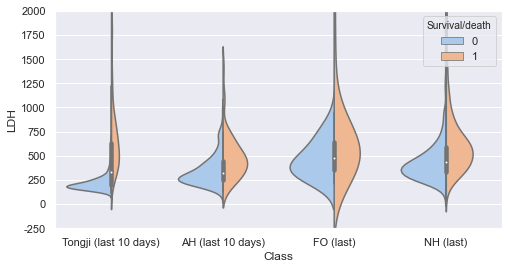

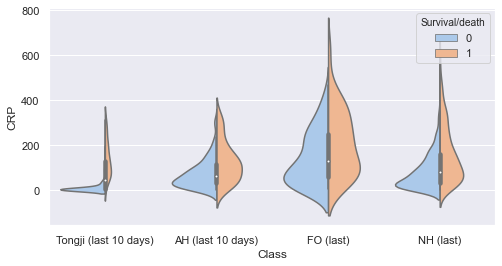

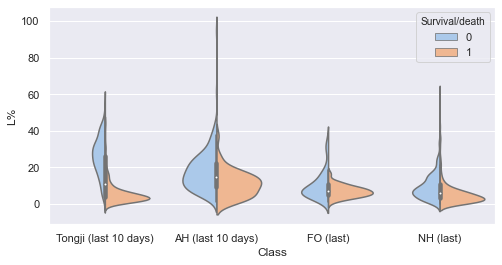

In [9]:
d_tj = load_tj_data()
d_nl = load_nl_data()
d_fr = load_fr_data()
d_ny = load_ny_data()

d = pd.concat([d_tj, d_nl, d_fr, d_ny])

plt.figure(figsize=(8, 4))
sns.violinplot(x='Class', y='LDH', hue='Survival/death', data=d, split=True)
plt.ylim(-250, 2000)
plt.savefig('figure/LDH', dpi=400, bbox_inches='tight')
plt.show()

plt.figure(figsize=(8, 4))
sns.violinplot(x='Class', y='CRP', hue='Survival/death', data=d, split=True)
plt.savefig('figure/CRP', dpi=400, bbox_inches='tight')
plt.show()

plt.figure(figsize=(8, 4))
sns.violinplot(x='Class', y='L%', hue='Survival/death', data=d, split=True)
plt.savefig('figure/L%', dpi=400, bbox_inches='tight')
plt.show()

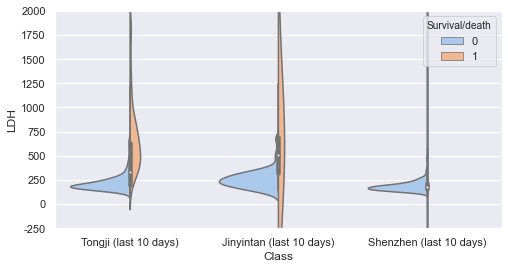

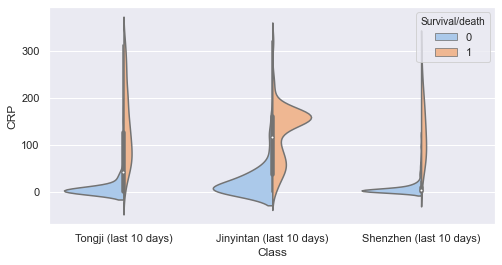

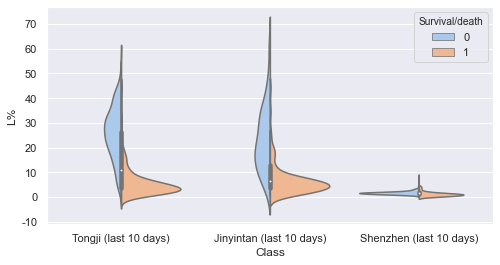

In [10]:
d_tj = load_tj_data()
d_jyt = load_jyt_data()
d_sz = load_sz_data()

d = pd.concat([d_tj, d_jyt, d_sz])

plt.figure(figsize=(8, 4))
sns.violinplot(x='Class', y='LDH', hue='Survival/death', data=d, split=True)
plt.ylim(-250, 2000)
plt.savefig('figure/LDH', dpi=400, bbox_inches='tight')
plt.show()

plt.figure(figsize=(8, 4))
sns.violinplot(x='Class', y='CRP', hue='Survival/death', data=d, split=True)
plt.savefig('figure/CRP', dpi=400, bbox_inches='tight')
plt.show()

plt.figure(figsize=(8, 4))
sns.violinplot(x='Class', y='L%', hue='Survival/death', data=d, split=True)
plt.savefig('figure/L%', dpi=400, bbox_inches='tight')
plt.show()

# The prediction result of decision tree in our paper

In [21]:
def decision_tree(x: pd.Series):
    """The decision tree in our paper
    example: df.apply(decision_tree, axis=1)

    :param x: a single sample，['LDH', 'CRP', 'L%']
    :return: 0: Survival, 1: Death
    """
    if x['LDH'] >= 365:
        return 1

    if x['CRP'] < 41.2:
        return 0

    if x['L%'] > 14.7:
        return 0
    else:
        return 1
    
def heatmap_conf_matrix(y_true, y_pred, save_path, title='Confusion Matrix'):
    LABELS = ['Survival', 'Death']
    conf = metrics.confusion_matrix(y_true, y_pred)
    
    plt.close('all')
    plt.figure(figsize=(3, 2))
    sns.heatmap(conf,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(save_path, dpi=500, bbox_inches='tight')
    plt.show()

def pred_and_plot(data, save_path, title):
    data['pred_tree'] = data.apply(decision_tree, axis=1)
    heatmap_conf_matrix(data['Survival/death'], data['pred_tree'], save_path, title)
    print(metrics.classification_report(data['Survival/death'], data['pred_tree']))

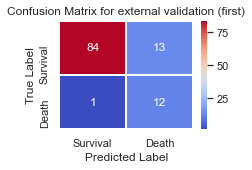

              precision    recall  f1-score   support

           0       0.99      0.87      0.92        97
           1       0.48      0.92      0.63        13

    accuracy                           0.87       110
   macro avg       0.73      0.89      0.78       110
weighted avg       0.93      0.87      0.89       110



In [11]:
p_read_110 = '../新冠荷兰数据/data/time_series_test_110.parquet'
df110 = pd.read_parquet(p_read_110)
df110 = merge_data_by_sliding_window(df110, subset=features_zh)
df110 = df110[features_zh+['出院方式']]
df110 = df110.groupby(level=0).last()     # descending + last() = first detection data
df110.columns = ['LDH', 'CRP', 'L%', 'Survival/death']
pred_and_plot(df110, 'figure/conf_tj110.png', 'Confusion Matrix for external validation (first)')

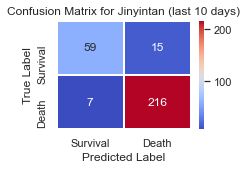

              precision    recall  f1-score   support

           0       0.89      0.80      0.84        74
           1       0.94      0.97      0.95       223

    accuracy                           0.93       297
   macro avg       0.91      0.88      0.90       297
weighted avg       0.92      0.93      0.92       297



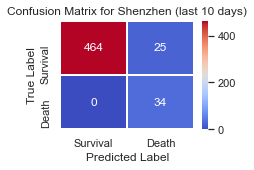

              precision    recall  f1-score   support

           0       1.00      0.95      0.97       489
           1       0.58      1.00      0.73        34

    accuracy                           0.95       523
   macro avg       0.79      0.97      0.85       523
weighted avg       0.97      0.95      0.96       523



In [22]:
pred_and_plot(load_jyt_data(), 'figure/conf_jinyintan.png',   'Confusion Matrix for Jinyintan (last 10 days)')
pred_and_plot(load_sz_data(),  'figure/conf_shenzhen.png',    'Confusion Matrix for Shenzhen (last 10 days)')

# mean(std)

## Tongji

In [22]:
def mean_std(df):
    survival = df.query("`Survival/death` == 0")
    death    = df.query("`Survival/death` == 1")
    print(f'\tTotal(N={len(df)})\tAlive(n={len(survival)})\tDecease(n={len(death)})')
    for feat in features_en:
        print(f"{feat}\t",
              f"{df[feat].mean():.3f}({df[feat].std():.3f})\t",
              f"{survival[feat].mean():.3f}({survival[feat].std():.3f})\t",
              f"{death[feat].mean():.3f}({death[feat].std():.3f})")

In [23]:
p_read_375 = '../新冠荷兰数据/data/time_series_375.parquet'
df375 = pd.read_parquet(p_read_375)
df375 = merge_data_by_sliding_window(df375, subset=features_zh)
df375 = df375[features_zh + ['出院方式']]
df375 = (
    df375
    .sort_index()
    .groupby(level=0).first()
)

p_read_110 = '../新冠荷兰数据/data/time_series_test_110.parquet'
df110 = pd.read_parquet(p_read_110)
df110 = merge_data_by_sliding_window(df110, subset=features_zh)
df110 = df110[features_zh+['出院方式']]
df110 = (
    df110
    .sort_index()
    .groupby(level=0).first()
)

df = pd.concat([df375, df110]).reset_index()
df = df.rename(columns={'乳酸脱氢酶': 'LDH', '超敏C反应蛋白': 'CRP', '淋巴细胞(%)': 'L%', '出院方式': 'Survival/death'})
mean_std(df)

	Total(N=454)	Alive(n=287)	Decease(n=167)
LDH	 419.747(369.759)	 224.003(79.009)	 756.144(426.916)
CRP	 55.458(77.372)	 11.714(23.941)	 130.635(79.718)
L%	 18.609(13.258)	 25.859(10.633)	 6.149(6.148)


## Netherlands

In [24]:
df = pd.read_excel("../新冠荷兰数据/data/Quanjel_dataset_1591655498_1.xlsx")
    
df = df[df['Date of discharge'] != 'No']
df['Date of discharge'] = pd.to_datetime(df['Date of discharge'])
df['diff'] = (df['Date of discharge'] - df['Date blood analysis']).dt.days

# Select the data and rename it
df['Survival/death'] = df['Survival/death'].map({'Alive': 0, 'Deceased': 1})
df = df.query("`diff` <= 3").reset_index(drop=True)
df = df.rename(columns={'LD': 'LDH',
                        'Percentage lymphocytes': 'L%'})
df = df[features_en + ['Survival/death']]
df['Class'] = 'AH (last 10 days)'
df['Survival/death'] = df['Survival/death'].astype(int)

mean_std(df)

	Total(N=135)	Alive(n=121)	Decease(n=14)
LDH	 343.193(174.803)	 319.190(139.206)	 550.643(290.477)
CRP	 69.444(71.305)	 62.686(64.220)	 127.857(101.189)
L%	 18.644(10.198)	 19.573(9.958)	 10.610(8.887)


## France

In [27]:
d_fr = load_fr_data()
mean_std(d_fr)

	Total(N=98)	Alive(n=62)	Decease(n=36)
LDH	 574.301(440.516)	 496.119(301.275)	 708.949(591.725)
CRP	 165.716(132.418)	 139.935(117.536)	 210.118(145.990)
L%	 9.030(6.475)	 10.194(7.562)	 7.026(3.163)


## New York

In [28]:
d_ny = load_ny_data()
mean_std(d_ny)

	Total(N=1038)	Alive(n=678)	Decease(n=360)
LDH	 500.045(285.147)	 425.677(213.954)	 640.106(344.129)
CRP	 109.134(104.450)	 82.492(79.408)	 159.309(125.530)
L%	 8.123(7.037)	 9.685(7.228)	 5.181(5.587)


# kolmogorov-Smirnov (K-S) test

In [8]:
d_tj = load_tj_data()
d_nl = load_nl_data()
d_fr = load_fr_data()
d_ny = load_ny_data()

print('Netherlands (AH)')
print('LDH\t', ks_2samp(d_tj['LDH'], d_nl['LDH']))
print('CRP\t', ks_2samp(d_tj['CRP'], d_nl['CRP']))
print('L%\t',  ks_2samp(d_tj['L%'], d_nl['L%']))

print('France (FO)')
print('LDH\t', ks_2samp(d_tj['LDH'], d_fr['LDH']))
print('CRP\t', ks_2samp(d_tj['CRP'], d_fr['CRP']))
print('L%\t',  ks_2samp(d_tj['L%'], d_fr['L%']))

print('New York (NH)')
print('LDH\t', ks_2samp(d_tj['LDH'], d_ny['LDH']))
print('CRP\t', ks_2samp(d_tj['CRP'], d_ny['CRP']))
print('L%\t',  ks_2samp(d_tj['L%'], d_ny['L%']))

Netherlands (AH)
LDH	 Ks_2sampResult(statistic=0.2097208314691324, pvalue=3.6186610297139765e-07)
CRP	 Ks_2sampResult(statistic=0.3119500607196881, pvalue=1.9984014443252818e-15)
L%	 Ks_2sampResult(statistic=0.2860571972360114, pvalue=5.103695244201845e-13)
France (FO)
LDH	 Ks_2sampResult(statistic=0.38262577758376076, pvalue=1.8546164604060777e-11)
CRP	 Ks_2sampResult(statistic=0.3513405362144858, pvalue=1.0816414430792065e-09)
L%	 Ks_2sampResult(statistic=0.32964094728800614, pvalue=1.4533176662112623e-08)
New York (NH)
LDH	 Ks_2sampResult(statistic=0.31306605669067417, pvalue=3.3306690738754696e-15)
CRP	 Ks_2sampResult(statistic=0.30915067025233633, pvalue=3.3306690738754696e-15)
L%	 Ks_2sampResult(statistic=0.31918127208844654, pvalue=3.3306690738754696e-15)


# Retrain

## Netherlands

In [12]:
model = XGBClassifier(max_depth=3, n_estimators=1)
d_nl = load_nl_data()
x = d_nl[['LDH', 'CRP', 'L%']]
y = d_nl['Survival/death']

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
accs = []
for tr_idx, te_idx in skf.split(x, y):
    x_tr = x.iloc[tr_idx]
    y_tr = y.iloc[tr_idx]
    x_te = x.iloc[te_idx]
    y_te = y.iloc[te_idx]
    
    clf = model.fit(x_tr, y_tr)
    pred = clf.predict(x_te)

    accs.append(metrics.accuracy_score(y_te, pred))

print(f"{np.mean(accs).round(2)} / {[acc.round(2) for acc in accs]}")

0.83 / [0.76, 0.82, 0.9, 0.82, 0.84]


## New York
Train with the last data and predict the last and first data

In [28]:
model = XGBClassifier(max_depth=3, n_estimators=1)
d_ny = load_ny_data()
x_tr = d_ny[['LDH', 'CRP', 'L%']]
y_tr = d_ny['Survival/death']
clf = model.fit(x_tr, y_tr)
pred = clf.predict(x_tr)

print(f"result accuracy of the last data：{metrics.accuracy_score(y_tr, pred):.2f}")


df = pd.read_csv('../新冠纽约数据/data/Zanos_Dataset_1_1593181746_12.csv', index_col=0)
df = df[['First_LDH', 'First_CRP', 'First_Lymph', 'Expired_Outcome']]
df.columns = features_en + ['Survival/death']
df = df.dropna(subset=['Survival/death'])
df = df.reset_index(drop=True)
df['Survival/death'] = df['Survival/death'].astype(int)

x_te = df[['LDH', 'CRP', 'L%']]
y_te = df['Survival/death']
pred = clf.predict(x_te)
print(f"result accuracy of the first data：{metrics.accuracy_score(y_te, pred):.2f}")

result accuracy of the last data：0.78
result accuracy of the first data：0.72
